# Connect to google account

In [1]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [2]:
# 코렙 한글깨짐 방지
!apt -qq -y install fonts-nanum > /dev/null

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=fontpath).get_name() 
fm._rebuild()  


%config InlineBackend.figure_format = 'retina'

plt.rc('font', family=font_name)  
plt.rcParams['axes.unicode_minus'] = False

# Global Variables

In [5]:
import easydict
import json
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/data/MyDrive/lecture/data/titanic/'
args.train_csv = args.default_path+'train.csv'
args.save_path = args.default_path+"model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 42
args.results = []
with open(args.save_path, 'r') as file:
    args.results = json.load(file)

args.results

[{'model': 'modelV0',
  'score_tr': 0.9759229534510433,
  'score_te': 0.7611940298507462,
  'len_features': 10,
  'dt': '0217'},
 {'model': 'modelV1',
  'score_tr': 0.9759229534510433,
  'score_te': 0.7611940298507462,
  'len_features': 10,
  'dt': '0217'},
 {'model': 'modelV2',
  'score_tr': 0.9759229534510433,
  'score_te': 0.7574626865671642,
  'len_features': 10,
  'dt': '0217'}]

# Load Tritanic

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- Sex:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [4]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [6]:
original = pd.read_csv(args.train_csv)

original.shape

(891, 12)

In [7]:
original.columns = [col.lower() for col in original.columns] # 컬럼명 소문자로 변환

original.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [8]:
original['passengerid'].nunique(), original.shape[0]

(891, 891)

In [9]:
original.drop('passengerid', axis=1, inplace=True)

original.columns

Index(['survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked'],
      dtype='object')

# train_test_split

In [10]:
new_survived = pd.Categorical(original["survived"])
new_survived = new_survived.rename_categories(["Died","Survived"])              

new_survived.describe()

,counts,freqs
categories,,
Died,549,0.616162
Survived,342,0.383838


In [11]:
from sklearn.model_selection import train_test_split

In [15]:
ori_tr, ori_te = train_test_split(original, test_size=0.3, stratify=original['survived'], random_state=args.random_state)

ori_tr.shape, ori_te.shape

((623, 11), (268, 11))

# EDA ModelV3

## EDA(Exploratory Data Analysis)

### Target Value
> Died / Survived = 6 / 4

In [16]:
new_survived = pd.Categorical(ori_tr["survived"])
new_survived = new_survived.rename_categories(["Died","Survived"])              

new_survived.describe()

,counts,freqs
categories,,
Died,384,0.616372
Survived,239,0.383628


### Missing Value
> cabin, age, embarked

In [17]:
(ori_tr.isnull() / ori_tr.shape[0]).sum().sort_values(ascending=False)

cabin       0.781701
age         0.191011
embarked    0.003210
survived    0.000000
pclass      0.000000
name        0.000000
sex         0.000000
sibsp       0.000000
parch       0.000000
ticket      0.000000
fare        0.000000
dtype: float64

In [18]:
(ori_te.isnull() / ori_te.shape[0]).sum().sort_values(ascending=False)

cabin       0.746269
age         0.216418
survived    0.000000
pclass      0.000000
name        0.000000
sex         0.000000
sibsp       0.000000
parch       0.000000
ticket      0.000000
fare        0.000000
embarked    0.000000
dtype: float64

### Analysing the features 

In [20]:
ori_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 748 to 136
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  623 non-null    int64  
 1   pclass    623 non-null    int64  
 2   name      623 non-null    object 
 3   sex       623 non-null    object 
 4   age       504 non-null    float64
 5   sibsp     623 non-null    int64  
 6   parch     623 non-null    int64  
 7   ticket    623 non-null    object 
 8   fare      623 non-null    float64
 9   cabin     136 non-null    object 
 10  embarked  621 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 58.4+ KB


In [22]:
continous_cols = ['age', 'fare']
ordinal_cols = ['pclass', 'sibsp', 'parch']
categorical_cols = ['sex', 'cabin', 'embarked']
other_cols = ['name', 'ticket']

#### continous features

In [32]:
ori_continous = ori_tr[continous_cols + ['survived']]
print(f'{ori_continous.shape}')
ori_continous.head()

(623, 3)


,age,fare,survived
748,19.0,53.1000,0
45,NaN,8.0500,0
28,NaN,7.8792,1
633,NaN,0.0000,0
403,28.0,15.8500,0


In [33]:
ori_continous.describe()

,age,fare,survived
count,504.000000,623.000000,623.000000
mean,30.045476,30.874003,0.383628
std,14.502377,47.760418,0.486660
min,0.420000,0.000000,0.000000
25%,21.000000,7.895800,0.000000
50%,29.000000,13.500000,0.000000
75%,39.000000,30.000000,1.000000
max,80.000000,512.329200,1.000000


In [34]:
ori_continous.corr()

,age,fare,survived
age,1.000000,0.084298,-0.108771
fare,0.084298,1.000000,0.279393
survived,-0.108771,0.279393,1.000000


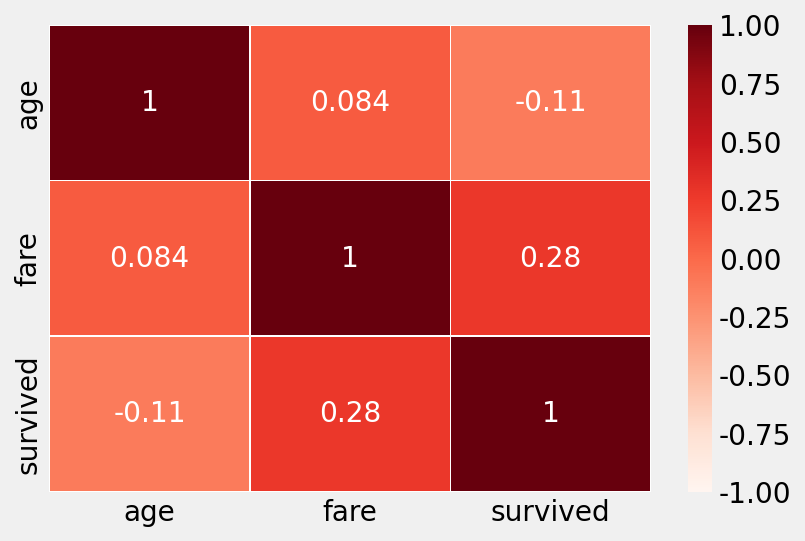

In [35]:
sns.heatmap(ori_continous.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='Reds')

#### ordinal features

In [36]:
ori_ordinal = ori_tr[ordinal_cols + ['survived']]
ori_ordinal.head()

,pclass,sibsp,parch,survived
748,1,1,0,0
45,3,0,0,0
28,3,0,0,1
633,1,0,0,0
403,3,1,0,0


In [37]:
ori_ordinal.describe()

,pclass,sibsp,parch,survived
count,623.000000,623.000000,623.000000,623.000000
mean,2.319422,0.457464,0.377207,0.383628
std,0.830909,0.964501,0.841409,0.486660
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000,0.000000
75%,3.000000,1.000000,0.000000,1.000000
max,3.000000,8.000000,6.000000,1.000000


In [38]:
ori_ordinal.corr()

,pclass,sibsp,parch,survived
pclass,1.000000,0.080173,0.050443,-0.335331
sibsp,0.080173,1.000000,0.367481,-0.014844
parch,0.050443,0.367481,1.000000,0.101484
survived,-0.335331,-0.014844,0.101484,1.000000


#### categorical features

In [41]:
ori_categorical = ori_tr[categorical_cols + ['survived']]
ori_categorical['survived'] = ori_categorical['survived'].astype('category')
ori_categorical.head()

,sex,cabin,embarked,survived
748,male,D30,S,0
45,male,NaN,S,0
28,female,NaN,Q,1
633,male,NaN,S,0
403,male,NaN,S,0


In [42]:
ori_categorical.describe()

,sex,cabin,embarked,survived
count,623,136,621,623
unique,2,113,3,2
top,male,F33,S,0
freq,406,3,444,384


#### other features

In [44]:
ori_other = ori_tr[other_cols + ['survived']]
ori_other.head()

,name,ticket,survived
748,"Marvin, Mr. Daniel Warner",113773,0
45,"Rogers, Mr. William John",S.C./A.4. 23567,0
28,"O'Dwyer, Miss. Ellen ""Nellie""",330959,1
633,"Parr, Mr. William Henry Marsh",112052,0
403,"Hakkarainen, Mr. Pekka Pietari",STON/O2. 3101279,0


In [45]:
ori_other.tail()

,name,ticket,survived
476,"Renouf, Mr. Peter Henry",31027,0
190,"Pinsky, Mrs. (Rosa)",234604,1
736,"Ford, Mrs. Edward (Margaret Ann Watson)",W./C. 6608,0
462,"Gee, Mr. Arthur H",111320,0
136,"Newsom, Miss. Helen Monypeny",11752,1


### Observations

In [46]:
df_observation = ori_tr.copy()
df_observation.shape

(623, 11)

add Initial_name

In [47]:
df_observation['Initial_name']=None
for i in df_observation:
    df_observation['Initial_name']=df_observation.name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

print(f'Initial null count: {df_observation["Initial_name"].isnull().sum()}')
df_observation.head()

Initial null count: 0


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,Initial_name
748,0,1,"Marvin, Mr. Daniel Warner",male,19.0,1,0,113773,53.1000,D30,S,Mr
45,0,3,"Rogers, Mr. William John",male,NaN,0,0,S.C./A.4. 23567,8.0500,NaN,S,Mr
28,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,Miss
633,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S,Mr
403,0,3,"Hakkarainen, Mr. Pekka Pietari",male,28.0,1,0,STON/O2. 3101279,15.8500,NaN,S,Mr


In [48]:
pd.crosstab(df_observation.Initial_name,df_observation.sex).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial_name,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mr,Mrs,Rev,Sir
sex,,,,,,,,,,,,,
female,0,0,1,0,1,0,0,122,2,0,91,0,0
male,2,1,5,1,0,1,26,0,0,364,0,5,1


In [49]:
df_observation['Initial_name'].unique()

array(['Mr', 'Miss', 'Mrs', 'Master', 'Col', 'Dr', 'Rev', 'Mlle', 'Major',
       'Lady', 'Jonkheer', 'Don', 'Sir'], dtype=object)

In [50]:
df_observation['Initial_name'].nunique()

13

add Initial_name_type

In [51]:
dict_initial = {
    'Mr': 'Others',
    'Master': 'Others',
    'Miss': 'Others',
    'Mrs': 'Others',
    'Ms': 'Others',
    'Mlle': 'Others',
    # 직업
    'Dr': 'Officer',
    'Rev': 'Officer',
    'Major': 'Officer',
    'Col': 'Officer',
    'Capt': 'Officer',
    # 귀족
    'Don': 'Royalty',
    'Sir': 'Royalty',
    'Lady': 'Royalty',
    'Mme': 'Royalty',
    'Countess': 'Royalty',
    'Jonkheer': 'Royalty'
}

In [52]:
df_observation['Initial_name_type'] = df_observation['Initial_name'].map(dict_initial)

print(f'Initial_type null count: {df_observation["Initial_name_type"].isnull().sum()}')
df_observation.head()

Initial_type null count: 0


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,Initial_name,Initial_name_type
748,0,1,"Marvin, Mr. Daniel Warner",male,19.0,1,0,113773,53.1000,D30,S,Mr,Others
45,0,3,"Rogers, Mr. William John",male,NaN,0,0,S.C./A.4. 23567,8.0500,NaN,S,Mr,Others
28,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,Miss,Others
633,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S,Mr,Others
403,0,3,"Hakkarainen, Mr. Pekka Pietari",male,28.0,1,0,STON/O2. 3101279,15.8500,NaN,S,Mr,Others


add Initial_cabin

In [53]:
def add_initial_cabin(cabin):
  try:
    cabin = cabin.strip()
    return cabin[:1]
  except:
    return 'unknown'

df_observation['initial_cabin'] = df_observation['cabin'].map(lambda cabin: add_initial_cabin(cabin))

print(f'initial_cabin null count: {df_observation["initial_cabin"].isnull().sum()} / cabin null count: {df_observation["cabin"].isnull().sum()}')
df_observation.head()

initial_cabin null count: 0 / cabin null count: 487


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,Initial_name,Initial_name_type,initial_cabin
748,0,1,"Marvin, Mr. Daniel Warner",male,19.0,1,0,113773,53.1000,D30,S,Mr,Others,D
45,0,3,"Rogers, Mr. William John",male,NaN,0,0,S.C./A.4. 23567,8.0500,NaN,S,Mr,Others,unknown
28,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,Miss,Others,unknown
633,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S,Mr,Others,unknown
403,0,3,"Hakkarainen, Mr. Pekka Pietari",male,28.0,1,0,STON/O2. 3101279,15.8500,NaN,S,Mr,Others,unknown


## Data Cleaning

## Feature Extraction

## Modeling